<br>

## ❗️ 전체 실습에서 GoogleDrive & Colab을 활용합니다.

- **colab_data** 폴더를 통째로 Google Drive에 업로드해주세요. (Colab Notebooks 폴더 옆)
- Colab 에서 실습 파일들을 실행해주세요.

<br>
<br>

# 0. Install & import libraries 

In [ ]:
!pip install konlpy==0.5.2

In [ ]:
import konlpy
import sklearn
print(konlpy.__version__) # 0.5.2
print(sklearn.__version__) # 0.22.2

0.5.2
0.22.2.post1


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import re
import tqdm
import urllib.request
from collections import Counter

from konlpy.tag import Okt 

# [ konlpy.tag.Mecab ] 사용 희망 시, 아래의 코드를 통해 먼저 설치 진행 후 import를 진행해주셔야 합니다 (리눅스 & Colab만 가능)
# (한국어 형태소 분석기 성능 비교 @ https://j.mp/3wTHrkw & https://j.mp/3rrSgJm)

# !git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
# %cd Mecab-ko-for-Google-Colab
# !bash install_mecab-ko_on_colab190912.sh
# from konlpy.tag import Mecab 

<br>
<br>

# 1. Load the data

In [ ]:
# Download the original data directly from github by using [ urlretrieve() ]
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt", filename="ratings_total.txt")

# - Original source @ https://github.com/bab2min/corpus
# - 네이버 쇼핑(https://shopping.naver.com/)에서 2020.06~2020.07 기간에 걸쳐 20만 건의 리뷰 텍스트를 별점(1~5점)과 함께 수집 
# - 3점에 해당하는 데이터를 삭제한 후, 1~2점(부정) & 4~5점(긍정) 데이터의 비율이 1:1에 가깝게 맞춰지도록 샘플링 진행

('ratings_total.txt', <http.client.HTTPMessage at 0x7fefd1d2bb10>)

In [ ]:
# or you can upload the file to Colab with the following codes.

# from google.colab import files
# uploaded = files.upload() # Please upload the file named "naver_shopping.txt"

In [ ]:
reviews_df = pd.read_table('ratings_total.txt', names=['ratings', 'reviews'])

print('전체 리뷰 수 :',len(reviews_df)) # 전체 리뷰 수 (중복 리뷰가 존재할 수 있음)

reviews_df.head(3)

전체 리뷰 수 : 200000


,ratings,reviews
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...


<br>
<br>

# 2. Preprocess the data

### 1) 중복 체크 & 중복 제거

In [ ]:
reviews_df[ reviews_df['reviews'].duplicated(keep=False) == True ].sort_values('reviews') # keep=False : Mark all duplicates as `True`. (생략 시 중복된 항목 중 하나만 꺼내줍니다.)

,ratings,reviews
8731,4,2022년까지 넉넉함
10958,5,2022년까지 넉넉함
95928,2,3년 동안 꾸준히 쓰는데 좋아요
137154,1,3년 동안 꾸준히 쓰는데 좋아요
89900,4,가격에 비해 가성비 좋습니다
...,...,...
18075,1,크기가 너무 작아요
56290,2,한사이즈 크게 주문하세요 스판기 없고 통풍 안됨
184478,1,한사이즈 크게 주문하세요 스판기 없고 통풍 안됨
195539,4,효과가 있는지 모르겠어요


In [ ]:
reviews_df = reviews_df.drop_duplicates('reviews') 
reviews_df = reviews_df.reset_index(drop=True)

print('중복 제거 후 전체 리뷰 수 :', len(reviews_df))

중복 제거 후 전체 리뷰 수 : 199908


<br> 

### 2) 리뷰 별점을 기준으로 하여 Label 열 생성 (긍정 == 1, 부정 == 0)

In [ ]:
reviews_df['label'] = reviews_df['ratings'].apply(lambda x : 1 if x > 3 else 0)

reviews_df.head(3)

,ratings,reviews,label
0,5,배공빠르고 굿,1
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,0
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...,1


In [ ]:
print(reviews_df['label'].value_counts() / len(reviews_df))

# 클래스 불균형 X

0    0.500005
1    0.499995
Name: label, dtype: float64


<br> 

### 3) 형태소 분석 (+ 불용어 제거)

In [ ]:
# [ whitespaces, 숫자, 영문 알파벳, 한글(+자모음) ]이 아닌 것을 공백으로 치환 (특수문자 제거)

text_test = re.sub("[^\s0-9a-zA-Zㄱ-ㅎㅏ-ㅣ가-힣]", "", '장마라 그런가!!! 달지않아요 ^^') # sub(pattern, repl, string, ...)
text_test

'장마라 그런가 달지않아요 '

In [ ]:
def tokenize_and_stemming(sentence, tokenizer):

    sentence = re.sub("[^\s0-9a-zA-Zㄱ-ㅎㅏ-ㅣ가-힣]", "", sentence) 
    
    raw_pos_tagged = tokenizer.pos(sentence, stem=True) # POS Tagging with stemming

    sentence_tokenized = []
    for token, pos in raw_pos_tagged: # ex) word <- ('서울', 'Noun')
        # pos 기준 제거 대상 : ["Josa", "Eomi", "Punctuation", "Foreign", "Number", "Suffix", "Determiner"]
        # 리뷰 텍스트 상 형태소의 순서를 고려하는 경우 의미를 갖게 됨 : "VerbPrefix" (잘/안/못), "Conjunction"(하지만/그러나/그리고), "KoreanParticle"(ㅋㅋㅋ/ㅎㅎㅎ/ㅠㅠ)
        if (len(token) != 1) & (pos in ["Noun", "VerbPrefix", "Verb", "Adverb", "Adjective", "Conjunction", "KoreanParticle"]):
            sentence_tokenized.append(token)  

    return sentence_tokenized

In [ ]:
# Colab 기준 10분 가량 소요됩니다.

okt = Okt()
tokenized_sentences = []

for sentence in tqdm.tqdm(reviews_df['reviews']):
    try:
        tokenized_sentences.append(tokenize_and_stemming(sentence, okt))
    except:
        print("Error occured at :", sentence)
        tokenized_sentences.append([])

reviews_df['reviews'] = tokenized_sentences

# reviews_df['reviews'] = reviews_df['reviews'].apply(tokenize_and_stemming, tokenizer=okt) # tqdm 미사용 시 1줄로도 적용 가능

In [ ]:
# 긍정 리뷰에 많이 포함되었던 형태소 체크

tokens_positive = []

for tokens_list in reviews_df[reviews_df['label'] == 1]['reviews']:
    tokens_positive.extend(eval(tokens_list)) 
    # eval()의 역할 : "['편하다', '가성', '최고']" (str) -> ['편하다', '가성', '최고'] (list)

tokens_positive_counted = Counter(tokens_positive)
tokens_positive_counted.most_common(20)

[('좋다', 49791),
 ('하다', 44499),
 ('배송', 16281),
 ('자다', 13484),
 ('너무', 12169),
 ('재다', 11753),
 ('있다', 11610),
 ('먹다', 11404),
 ('같다', 10511),
 ('빠르다', 10254),
 ('구매', 9529),
 ('사용', 7208),
 ('가격', 6687),
 ('이다', 6677),
 ('만족하다', 6515),
 ('맛있다', 6342),
 ('쓰다', 6147),
 ('사다', 6107),
 ('되다', 5849),
 ('보다', 5655)]

In [ ]:
# 부정 리뷰에 많이 포함되었던 형태소 체크

tokens_negative = []

for tokens_list in reviews_df[reviews_df['label'] == 0]['reviews']:
    tokens_negative.extend(eval(tokens_list)) 
    # eval()의 역할 : "['편하다', '가성', '최고']" (str) -> ['편하다', '가성', '최고'] (list)

tokens_negative_counted = Counter(tokens_negative)
tokens_negative_counted.most_common(20)

[('하다', 52669),
 ('너무', 17582),
 ('배송', 12194),
 ('같다', 11903),
 ('없다', 11414),
 ('좋다', 11195),
 ('있다', 10712),
 ('않다', 10640),
 ('그냥', 10507),
 ('오다', 9377),
 ('이다', 8168),
 ('쓰다', 7904),
 ('되다', 7722),
 ('별로', 7436),
 ('사다', 7332),
 ('아니다', 7160),
 ('보다', 6809),
 ('자다', 6746),
 ('제품', 6733),
 ('생각', 6588)]

<br> 

### 4) 전처리 적용 후 데이터 중간 저장 @ Google Drive 

In [ ]:
# Colab 런타임 초기화를 대비해 구글드라이브에 현재까지 처리를 마친 데이터를 저장

from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
# 1) Save
data_path = '/gdrive/MyDrive/colab_data/temp_data/' 

# 구글 드라이브 내 "data_path" 경로의 폴더가 존재하지 않을 시 새로이 생성
if not os.path.exists(data_path): 
    os.makedirs(data_path)

reviews_df.to_csv(data_path + 'data_reviews_tokenized.csv', encoding='utf-8', index=False)


# 2) Load
# data_path = '/gdrive/MyDrive/colab_data/temp_data/' 
# reviews_df = pd.read_csv(data_path + 'data_reviews_tokenized.csv', encoding='utf-8')
# reviews_df['reviews'] = reviews_df['reviews'].apply(eval)
# reviews_df

<br>
<br>

# 3. Modeling - Traditional ML (XGBoost)

In [ ]:
from sklearn import model_selection
from sklearn.feature_extraction.text import TfidfVectorizer # CountVectorizer
from sklearn.metrics import accuracy_score

from xgboost import XGBClassifier # version : 0.90

In [ ]:
train_x, test_x, train_y, test_y = model_selection.train_test_split(reviews_df['reviews'], reviews_df['label'], 
                                                                    test_size=0.3, 
                                                                    random_state=42) 

# 별도로 stratify 파라미터 값을 지정하지 않아도 자동으로 클래스 비율이 유지됨
# print(train_y.value_counts() / len(train_y))

In [ ]:
# 각각의 문서에 해당하는 데이터가 단순 문자열(ex. '물건이 정말 좋습니다')이 아니라, 
# 각 단어들에 대한 문자열을 모은 하나의 리스트(ex. ['물건이', '정말', '좋습니다'])로 주어질 경우,
# 아래와 같이 Vectorizer를 설정하여 들어온 리스트를 그대로 받아들이도록 해주고 (tokenizer & token_pattern) 
# 단순 문자열이 아니기에 발생하는 .lower() 함수(Vectorizer 내부에서 작동됨)의 에러를 막아줍니다.

# 아래 TfidfVectorizer() 에서 tokenizer 파라미터에게 lambda 함수를 넣어줄 수도 있으나, 이 경우 추후 vectorizer의 저장이 불가합니다. (https://j.mp/3y6cjjg)
def list_to_list(doc):
    return doc

vectorizer = TfidfVectorizer(tokenizer=list_to_list, token_pattern=None, lowercase=False) # CountVectorizer 적용 시 아주 약간 성능 저하 (88.15% -> 88.02%)
vectorizer.fit(train_x)

train_x_vector = vectorizer.transform(train_x) # .toarray() 함수를 연달아 적용하면 np.array 형태로 만들어진 행렬을 확인할 수 있으나, RAM이 초과되어 Colab이 초기화됩니다. 
test_x_vector = vectorizer.transform(test_x) 

In [ ]:
model_xgb = XGBClassifier(max_depth=4, 
                          n_estimators=1500, # 500 -> 86 / 1000 -> 87 / 1500 -> 88
                          random_state=42) 

model_xgb.fit(train_x_vector, train_y, 
              early_stopping_rounds=10, # check for no improvement in log-loss(evaluation metric이 여러가지인 경우 마지막 metric이 기준) over the 10 epochs
              eval_metric=["error", "logloss"], # error == binary classification error, logloss == cross-entropy <- + merror, auc, rmse, mae, etc @ https://j.mp/3eTsUiF
              eval_set=[(train_x_vector, train_y), (test_x_vector, test_y)])

In [ ]:
print('Training accuracy :', round(accuracy_score(model_xgb.predict(train_x_vector), train_y), 4))
print('Test accuracy :', round(accuracy_score(model_xgb.predict(test_x_vector), test_y), 4))

Training accuracy : 0.8986
Test accuracy : 0.8815


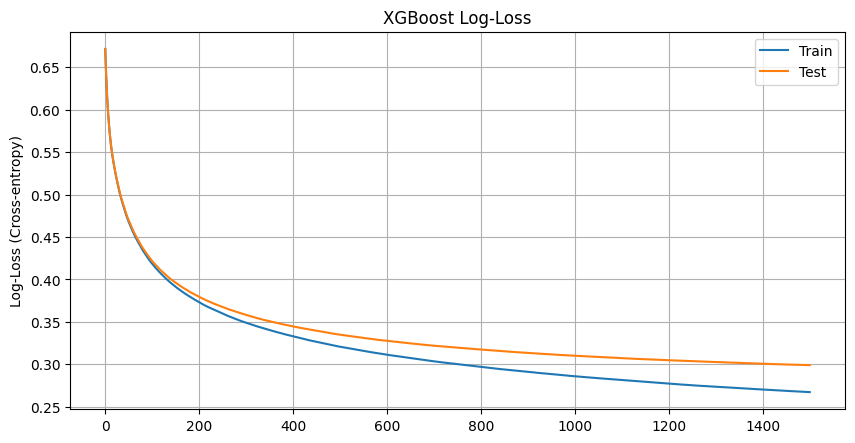

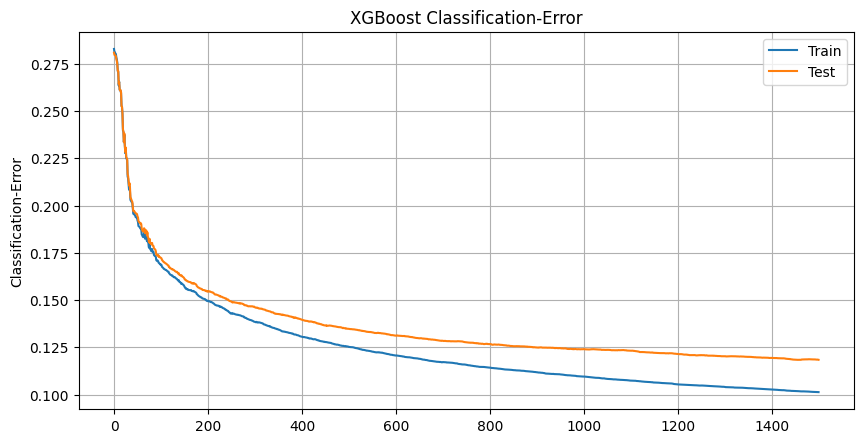

In [ ]:
# retrieve performance metrics
results = model_xgb.evals_result() # validation_0 == Training data, validation_1 == Test data
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

# plot log-loss
fig, ax = plt.subplots(dpi=100, figsize=(10, 5))
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
ax.grid()
plt.ylabel('Log-Loss (Cross-entropy)')
plt.title('XGBoost Log-Loss')
plt.show()

# plot classification-error
fig, ax = plt.subplots(dpi=100, figsize=(10, 5))
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
ax.grid()
plt.ylabel('Classification-Error')
plt.title('XGBoost Classification-Error')
plt.show()

In [ ]:
# # GridSearch for XGBoost (max_depth & subsample)
# # Use the following codes if needed, it will take too much time.

# model_xgb = XGBClassifier()

# xgb_param_grid = {'max_depth': [3, 5, 7], 
#                   'n_estimators': [100], # 300, 500, 700, 1000
#                   'subsample': [0.6, 0.8, 1.0],
#                   'random_state': [42]}

# xgb_gridcv = model_selection.GridSearchCV(estimator=model_xgb,
#                                           param_grid=xgb_param_grid,
#                                           scoring='accuracy', # roc_auc, neg_log_loss, precision, recall, neg_mean_absolute_error, r2, etc @ https://j.mp/3y79Kx8
#                                           n_jobs=-1, # Number of jobs to run in parallel (-1 means using all processors) @ https://j.mp/3yigAjP
#                                           cv=5,
#                                           refit=True, 
#                                           return_train_score=True, # include training scores (can be computationally expensive)
#                                           verbose=1)
# xgb_gridcv.fit(train_x_vector, train_y)


# best_score = xgb_gridcv.best_score_
# best_row = xgb_gridcv.best_index_

# best_max_depth     = xgb_gridcv.best_params_["max_depth"]
# best_max_subsample = xgb_gridcv.best_params_["subsample"]

# print(best_score, best_row, best_max_depth, best_max_subsample)

# xgb_grid_df = pd.DataFrame(xgb_gridcv.cv_results_)
# xgb_gridcv.loc[:, ['mean_test_score', "params"]]
# # xgb_gridcv[xgb_gridcv['rank_test_score'] == 1]

<br>
<br>

# + Model & Vectorizer Save/Load -> Predict on a new sentence

### 1) Save the model & vectorizer

In [ ]:
from sklearn.externals import joblib
from google.colab import drive

drive.mount('/gdrive')

data_path = '/gdrive/MyDrive/colab_data/temp_data/' 
if not os.path.exists(data_path): 
    os.makedirs(data_path)

joblib.dump(model_xgb, data_path+'model_xgb_tfidf_v1.pkl', compress=True) # Model 저장
joblib.dump(vectorizer, data_path+'vectorizer_tfidf.pkl', compress=True) # Vectorizer 저장

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


['/gdrive/MyDrive/colab_data/temp_data/vectorizer_tfidf.pkl']

### 2) Load the model & vectorizer -> Predict on new sentences

In [ ]:
from sklearn.externals import joblib
from google.colab import drive

drive.mount('/gdrive')
data_path = '/gdrive/MyDrive/colab_data/temp_data/' 

model_xgb = joblib.load(data_path+'model_xgb_tfidf_v1.pkl')
vectorizer = joblib.load(data_path+'vectorizer_tfidf.pkl')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
# def tokenize_and_stemming(sentence, tokenizer):

#     sentence = re.sub("[^\s0-9a-zA-Zㄱ-ㅎㅏ-ㅣ가-힣]", "", sentence) 
    
#     raw_pos_tagged = tokenizer.pos(sentence, stem=True) # POS Tagging with stemming

#     sentence_tokenized = []
#     for token, pos in raw_pos_tagged: # ex) word <- ('서울', 'Noun')
#         # pos 기준 제거 대상 : ["Josa", "Eomi", "Punctuation", "Foreign", "Number", "Suffix", "Determiner"]
#         # 리뷰 텍스트 상 형태소의 순서를 고려하는 경우 의미를 갖게 됨 : "VerbPrefix" (잘/안/못), "Conjunction"(하지만/그러나/그리고), "KoreanParticle"(ㅋㅋㅋ/ㅎㅎㅎ/ㅠㅠ)
#         if (len(token) != 1) & (pos in ["Noun", "VerbPrefix", "Verb", "Adverb", "Adjective", "Conjunction", "KoreanParticle"]):
#             sentence_tokenized.append(token)  

#     return sentence_tokenized

### Predict on a single sentence

In [ ]:
new_sentence = "아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 엉성하긴 하지만 편하고 가성비 최고예요."

okt = Okt()
tokenized_sentences = []
tokenized_sentences.append(tokenize_and_stemming(new_sentence, okt))

new_sentence_vector = vectorizer.transform(tokenized_sentences) 

print(model_xgb.predict_proba(new_sentence_vector))
print(model_xgb.predict(new_sentence_vector))

[[0.00161898 0.998381  ]]
[1]


### Predict on multiple sentences

In [ ]:
new_sentences = ["아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 엉성하긴 하지만 편하고 가성비 최고예요.",
                "너무 맛있어요! 4명이 먹을거라 넉넉하게 샀다했는데 순식간에 없어집니다! 꼭 드셔보세요!", 
                "후기 좋아서 샀는데 진짜 별로에요... 재질두 비니루같은 재질....", 
                "내용물이 안나와요 ㅜㅜ 무용지물 ㅜㅜ 여러개 샀는데 ㅜㅜ"
                ]

okt = Okt()
tokenized_sentences = []

for sentence in new_sentences:
    tokenized_sentences.append(tokenize_and_stemming(sentence, okt))

new_sentence_vector = vectorizer.transform(tokenized_sentences) 

print(model_xgb.predict_proba(new_sentence_vector))

[[0.00161898 0.998381  ]
 [0.01568407 0.98431593]
 [0.81362385 0.18637617]
 [0.9527507  0.04724932]]
